In [1]:
import pandas as pd
import torch
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import datasets
import transformers
import os


/data/minorai7/condaenv/dnab311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()
os.environ["CUDA_VISIBLE_DEVICES"]="1"

print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [3]:
! cd ./CapstoneProject_Guide-RNA/
! pwd
! ls

/bin/bash: line 1: cd: ./CapstoneProject_Guide-RNA/: No such file or directory


/home/minorai7/CapstoneProject_Guide-RNA/bert/DNABERT_2-main
 bertcristlESPTest.ipynb        results3
 bertcristl.ipynb	        results4
 DNABERT2117M		        results6_Froze_DNABert2_Layers
 figures		       'RobinTrainDNABert copy.ipynb'
 finetune		        RobinTrainDNABertHF0.22.ipynb
 LICENSE		        RobinTrainDNABertHFRegression.ipynb
 models			        RobinTrainDNABert.ipynb
 README.md		        sample_data
 requirements.txt	        test.py
 result5_SameAs4NoNewDownload   testting.ipynb
 results1		        Untitled.ipynb
 results2


In [4]:
modelpath = "zhihan1996/DNABERT-2-117M"

datapath  = '/home/minorai7/CapstoneProject_Guide-RNA/bert/DNABERT_2-main'

df_train = pd.read_csv(f"{datapath}/sample_data/esp/train_esp_decoded.csv")
df_test = pd.read_csv(f"{datapath}/sample_data/esp/test_esp_decoded.csv")

print(df_train.info())
print(df_train.head())

print(df_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46893 entries, 0 to 46892
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   seq     46893 non-null  object 
 1   y       46893 non-null  float64
dtypes: float64(1), object(1)
memory usage: 732.8+ KB
None
                     seq         y
0  GCCTGCGAAAAGAGCACGCGC  0.327296
1  GAGGGGGCCGAGTCGATACTC  0.188169
2  GTCTTTGTATCACATCGCAGT  0.274519
3  ACATCCTCCAGGTTTGCCAAA  0.184805
4  GGCCCATTAGTCGAAGGATGA  0.272028
(11724, 2)


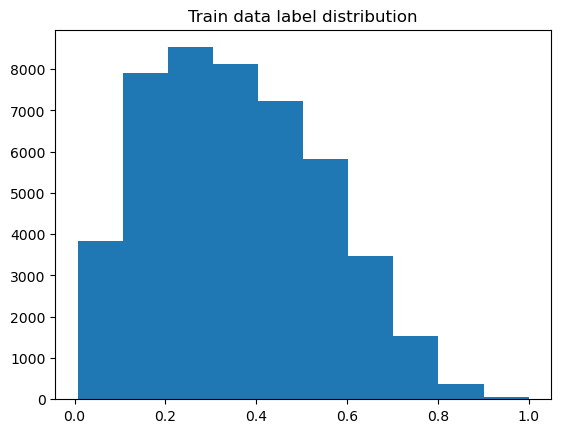

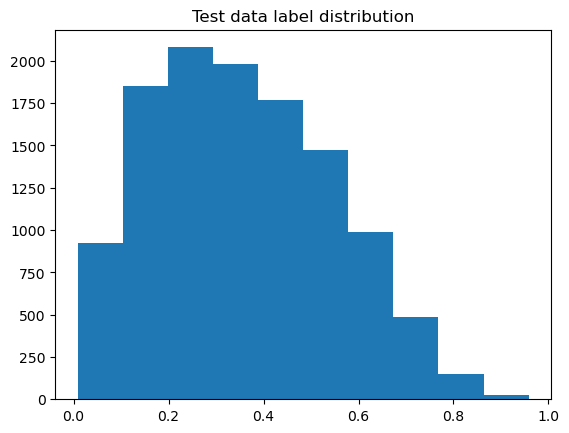

In [5]:
#plot label distribution of test and train data
plt.title("Train data label distribution")
plt.hist(df_train['y'])
plt.show()

plt.title("Test data label distribution")
plt.hist(df_test['y'])
plt.show()

In [6]:
#turn df into a dataset
raw_dataset_train = datasets.Dataset.from_pandas(df_train)
raw_dataset_test = datasets.Dataset.from_pandas(df_test)

print(raw_dataset_train)
print(raw_dataset_test)

Dataset({
    features: ['seq', 'y'],
    num_rows: 46893
})
Dataset({
    features: ['seq', 'y'],
    num_rows: 11724
})


In [7]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
        modelpath,
        
        model_max_length=100,
        padding_side="right",
        use_fast=True,
        trust_remote_code=True,
    )

In [8]:
def tokenize_function(example):
    return tokenizer(example["seq"], truncation=True)

tokenized_dataset_train = raw_dataset_train.map(tokenize_function, batched=True)
tokenized_dataset_train.set_format("torch")

print(tokenized_dataset_train)

tokenized_dataset_test = raw_dataset_test.map(tokenize_function, batched=True)
tokenized_dataset_test.set_format("torch")

print(tokenized_dataset_test)

Dataset({
    features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 46893
})


Dataset({
    features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 11724
})


In [9]:
def clean_tokenized_dataset(dataset):
    dataset = dataset.remove_columns(["seq"])
    dataset = dataset.rename_column("y", "labels")
    dataset.set_format("torch")

    print(dataset.column_names)
    return dataset

tokenized_dataset_train = clean_tokenized_dataset(tokenized_dataset_train)
tokenized_dataset_test = clean_tokenized_dataset(tokenized_dataset_test)

print(tokenized_dataset_train)
print(tokenized_dataset_test)

['labels', 'input_ids', 'token_type_ids', 'attention_mask']
['labels', 'input_ids', 'token_type_ids', 'attention_mask']
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 46893
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 11724
})


In [10]:
print(tokenizer.pad_token_id)
print(tokenizer.model_max_length)

data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt", padding="longest", max_length=tokenizer.model_max_length)

3
100


In [68]:
import torch.nn as nn
from transformers import AutoModel,AutoConfig
from torch.nn import MSELoss


class CustomModel(nn.Module):
  def __init__(self): 
    super(CustomModel,self).__init__() 

    #Load Model with given checkpoint and extract its body
    self.model = AutoModel.from_pretrained(
        modelpath,
        cache_dir=None,
        #num_labels=1,
        trust_remote_code=True,
        ignore_mismatched_sizes=True
      )
    
    self.dropout = nn.Dropout(0.1) 
    self.classifier = nn.Linear(768, 1) # load and initialize weights

  def forward(self, input_ids=None, attention_mask=None,labels=None):
    #Extract outputs from the body
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

    #Add custom layers
    sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state

    logits = self.classifier(sequence_output[:,0,:].view(-1,768)) # calculate losses
    
    loss = None
    if labels is not None:
      loss_fct = MSELoss()
      loss = loss_fct(logits.view(-1), labels.view(-1))
    
    return {"loss" : loss, "logits" : logits, labels : labels}

In [69]:
# model = transformers.AutoModelForSequenceClassification.from_pretrained(
#     modelpath,
#     cache_dir=None,
#     num_labels=1,
#     trust_remote_code=True,
#     ignore_mismatched_sizes=True
# ).cuda()


model = CustomModel().cuda()


Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
/home/minorai7/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/25abaf0bd247444fcfa837109f12088114898d98/bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected i

In [70]:
model

CustomModel(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4096, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_features=768, out_fea

In [71]:
#freeze pretrained bert parameters
for name, param in model.named_parameters():
     if name.startswith("bert"): 
        param.requires_grad = False

In [72]:
import torchmetrics
from torchmetrics.regression import R2Score

def compute_metrics(logits, labels):
    #reshape logits and labels
    logits = logits.view(-1)

    #calculate metrics using torchmetrics
    mse = torchmetrics.functional.mean_squared_error(logits, labels)
    rmse = torch.sqrt(mse)
    mae = torchmetrics.functional.mean_absolute_error(logits, labels)

    #spearmans rho
    rho = torchmetrics.functional.pearson_corrcoef(logits, labels)

    r2 = R2Score().to(device)(logits, labels)

    return {"mse": mse.item(), "rmse": rmse.item(), "mae": mae.item(), "r2": r2.item(), "rho": rho.item()}

In [73]:
resultname = "results7_CustomModel"

# Specifiy the arguments for the trainer  
training_args = transformers.TrainingArguments(
    output_dir =f'{datapath}/{resultname}',
    num_train_epochs = 40,     
    per_device_train_batch_size = 512,   
    per_device_eval_batch_size = 256,   
    weight_decay = 0.01,               
    learning_rate = 3e-5,
    logging_dir = './logs',
    logging_steps = 10,        
    save_total_limit = 3,
    load_best_model_at_end = True,     
    metric_for_best_model = 'r2',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
) 

# Call the Trainer
trainer = transformers.Trainer(
    model = model,                         
    args = training_args,                  
    train_dataset = tokenized_dataset_train,         
    eval_dataset = tokenized_dataset_test,          
    compute_metrics = compute_metrics,
    data_collator = data_collator, 
)

# Train the model
trainer.train()

# Call the summary
trainer.evaluate()

# Save the model
trainer.save_model(f"{datapath}/models/{resultname}")

/data/minorai7/condaenv/dnab311/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2
1,0.037800,0.035182,0.035182,0.187568,0.157731,-0.009898
2,0.035600,0.034742,0.034742,0.186393,0.156410,0.002722
3,0.036100,0.034446,0.034446,0.185597,0.154901,0.011220


  0%|          | 0/14655 [08:41<?, ?it/s]


KeyboardInterrupt: 

  0%|          | 0/14655 [08:09<?, ?it/s]

In [ ]:
# Call the summary
trainer.evaluate()

{'eval_loss': 0.03483588993549347,
 'eval_mse': 0.03483588993549347,
 'eval_rmse': 0.18664374947547913,
 'eval_mae': 0.15514329075813293,
 'eval_r2': 3.230352103344991e-05,
 'eval_runtime': 1.4288,
 'eval_samples_per_second': 8205.404,
 'eval_steps_per_second': 32.195,
 'epoch': 40.0}

In [ ]:
df = pd.DataFrame(trainer.state.log_history)


dfstep = df[['step', 'loss', 'learning_rate', 'epoch']].dropna()
dfepoch = df[['epoch', 'eval_loss', 'eval_mse', 'eval_rmse', 'eval_mae', 'eval_r2']].dropna()

#create results folder if not exist
if not os.path.exists(f"{datapath}/{resultname}"):
    os.makedirs(f"{datapath}/{resultname}")

#save to file
df.to_csv(f"{datapath}/{resultname}/df.csv")
dfstep.to_csv(f"{datapath}/{resultname}/dfstep.csv")
dfepoch.to_csv(f"{datapath}/{resultname}/dfepoch.csv")
print("saved to file")

saved to file


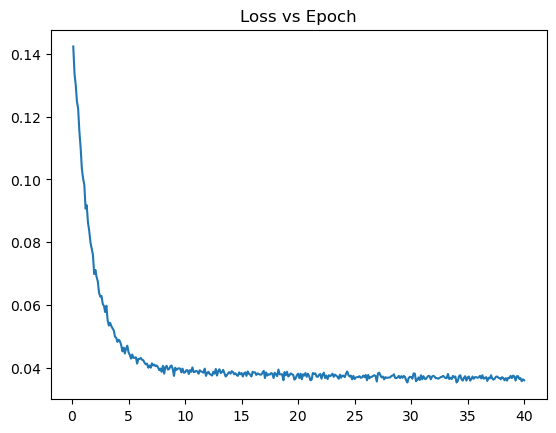

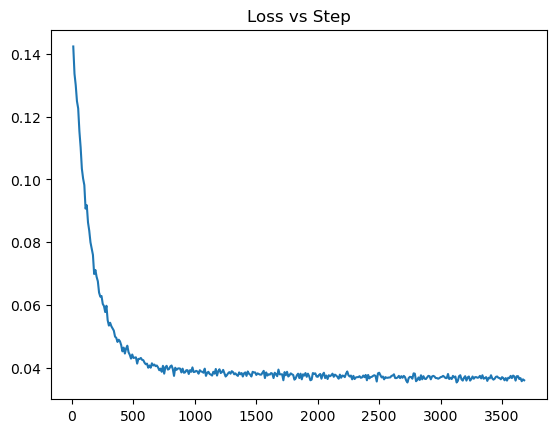

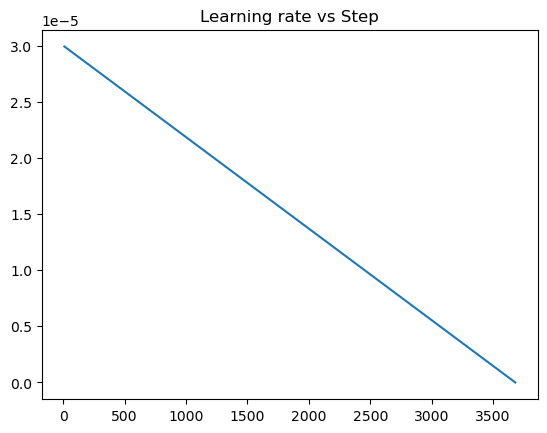

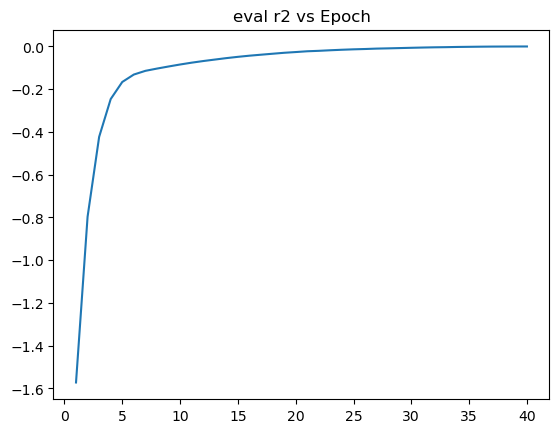

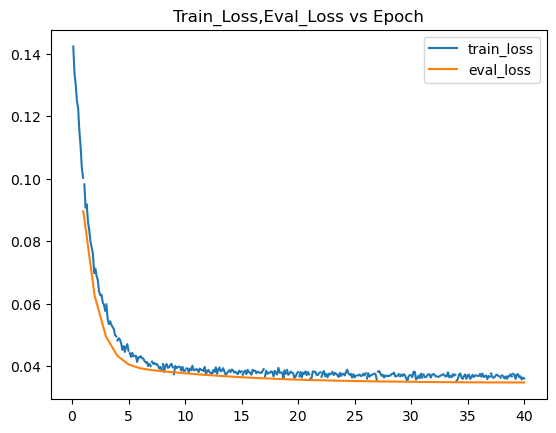

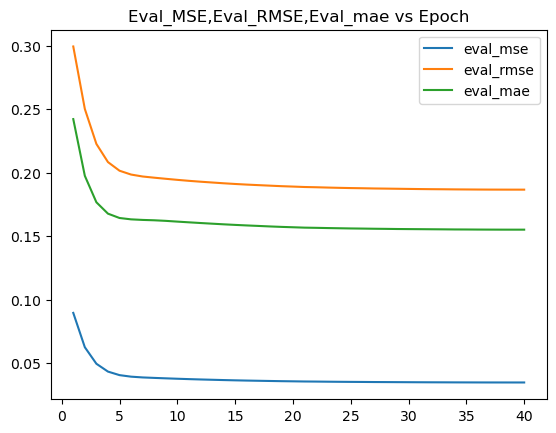

<Figure size 640x480 with 0 Axes>

In [ ]:
#plot loss vs epoch
plt.title("Loss vs Epoch")
plt.plot(dfstep['epoch'], dfstep['loss'])
plt.show()
plt.savefig(f"{datapath}/{resultname}/loss_vs_Epoch.png")
plt.clf()

#plot loss vs step
plt.title("Loss vs Step")
plt.plot(dfstep['step'], dfstep['loss'])
plt.show()
plt.savefig(f"{datapath}/{resultname}/loss_vs_step.png")
plt.clf()

#plot learning rate vs step
plt.title("Learning rate vs Step")
plt.plot(dfstep['step'], dfstep['learning_rate'])
plt.show()
plt.savefig(f"{datapath}/{resultname}/learning_rate_vs_step.png")
plt.clf()

#plot loss vs epoch
plt.title("eval r2 vs Epoch")
plt.plot(dfepoch['epoch'], dfepoch['eval_r2'])
plt.show()
plt.savefig(f"{datapath}/{resultname}/eval_r2_vs_epoch.png")
plt.clf()

#plot eval_loss and loss vs epoch ignore nan from eval_loss
plt.title("Train_Loss,Eval_Loss vs Epoch")
plt.plot(df['epoch'], df['loss'], label='train_loss')
plt.plot(dfepoch['epoch'], dfepoch['eval_loss'], label='eval_loss')
plt.legend()
plt.show()
plt.savefig(f"{datapath}/{resultname}/loss_vs_epoch.png")
plt.clf()


#plot eval_mse and eval_rmse vs epoch
plt.title("Eval_MSE,Eval_RMSE,Eval_mae vs Epoch")
plt.plot(dfepoch['epoch'], dfepoch['eval_mse'], label='eval_mse')
plt.plot(dfepoch['epoch'], dfepoch['eval_rmse'], label='eval_rmse')
plt.plot(dfepoch['epoch'], dfepoch['eval_mae'], label='eval_mae')
plt.legend()
plt.show()
plt.savefig(f"{datapath}/{resultname}/eval_mse_rmse_mae_vs_epoch.png")
plt.clf()


In [ ]:

# from tqdm.auto import tqdm

# model = transformers.AutoModelForSequenceClassification.from_pretrained(
#     "./resultsGPU4r2/checkpoint-4500",
#     cache_dir=None,
#     num_labels=1,
#     trust_remote_code=True,
# )

# model.cuda()

# #metric = evaluate.load("accuracy")
# #model.eval()

# mselist = []
# rmse_list = []
# mae_list = []
# r2_list = []
# difflist = []

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for batch in eval_dataloader:
#     batch = {k: v.to(device) for k, v in batch.items()}

#     labels = batch["labels"].reshape(-1, 1)

#     with torch.no_grad():
#         outputs = model(**batch)
    
#     #calculate metrics

#     logits = outputs["logits"]
    
#     #print(outputs)

#     #use cpu to calculate metrics
#     logits = logits.cpu()
#     labels = labels.cpu()

#     mse = mean_squared_error(labels, logits)
#     rmse = mean_squared_error(labels, logits, squared=False)
#     mae = mean_absolute_error(labels, logits)
#     r2 = r2_score(labels, logits)
#     #smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

#     diff = (labels[i]-logits[i]).item()
#     #print("mse: ", mse, " rmse: ", rmse, " mae: ", mae, " r2: ", r2)
#     #for i in range(len(labels)):
#         #print("Pred=", logits[i].item(), "    Act=" , labels[i].item(), "    diff=", diff)
    
#     mselist.append(mse)
#     rmse_list.append(rmse)
#     mae_list.append(mae)
#     r2_list.append(r2)
#     difflist.append(diff)

# print("AVG mse: ", np.mean(mselist), " rmse: ", np.mean(rmse_list), " mae: ", np.mean(mae_list), " r2: ", np.mean(r2_list))
# print("Diff mean=",np.mean(difflist),"  max: ", np.max(difflist),"  min: ", np.min(difflist), "  AVG= ", np.sum(np.abs(difflist)) / len(difflist) )
